In [127]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import kstest, shapiro

import sys
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns', None)

In [128]:
df = pd.read_csv("/content/drive/MyDrive/Churn_Modelling.csv")

In [129]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [130]:
df.shape

(10000, 14)

# Data Preprocessing

In [131]:
# Missing values Handling

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no missing or null values

In [133]:
# Duplicated values handling
df.duplicated().sum()

0

No Duplicate Data

In [134]:
# Label and One Hot Encoding

In [135]:
mapping_gender = {
    'Male' : 0 ,
    "Female": 1
}
df['Gender'] = df["Gender"].map(mapping_gender)

In [136]:
for cat in ["Geography"]:
  onehots = pd.get_dummies(df[cat],prefix= cat)
  df = df.join(onehots)

In [137]:
# split data

In [138]:
X = df[['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain']]
y = df[['Exited']]

df["Geography_France"] = df["Geography_France"].astype(int)
df["Geography_Germany"] = df["Geography_Germany"].astype(int)
df["Geography_Spain"] = df["Geography_Spain"].astype(int)

df["Geography_France"] = df["Geography_France"].replace({True: 1, False: 0})
df["Geography_Germany"] = df["Geography_Germany"].replace({True: 1, False: 0})
df["Geography_Spain"] = df["Geography_Spain"].replace({True: 1, False: 0})


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [139]:
# outlier handling

In [140]:
df_train = X_train.join(y_train)
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
9069,619,1,32,4,175406.13,2,1,1,172792.43,False,False,True,1
2603,643,1,34,7,160426.07,1,0,1,188533.11,False,True,False,0
7738,561,0,33,6,0.00,2,0,0,173680.39,True,False,False,0
1579,618,0,41,8,37702.79,1,1,1,195775.48,False,True,False,0
5058,714,0,37,9,148466.93,2,0,1,151280.96,True,False,False,0


In [141]:
numcols = ['CreditScore',"Age","Balance","EstimatedSalary"]

In [142]:
from scipy import stats

print(f'{len(df_train)} rows before outlier filtering')

filtered_entries = np.array([True] * len(df_train))

for col in numcols:
  zscore = abs(stats.zscore(df_train[col]))
  filtered_entries = (zscore < 3) & filtered_entries

df_train = df_train[filtered_entries]

print(f'{len(df_train)} rows after outlier filtering')


7000 rows before outlier filtering
6903 rows after outlier filtering


In [143]:
# Feature Transformation

<Axes: xlabel='Age', ylabel='Density'>

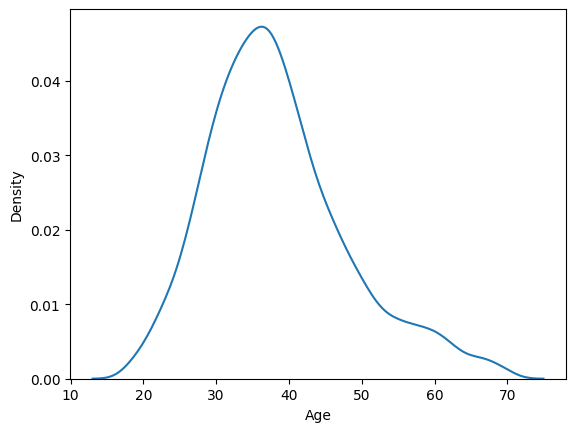

In [144]:
sns.kdeplot(x = 'Age' ,data = df_train)

<Axes: xlabel='log_Age', ylabel='Density'>

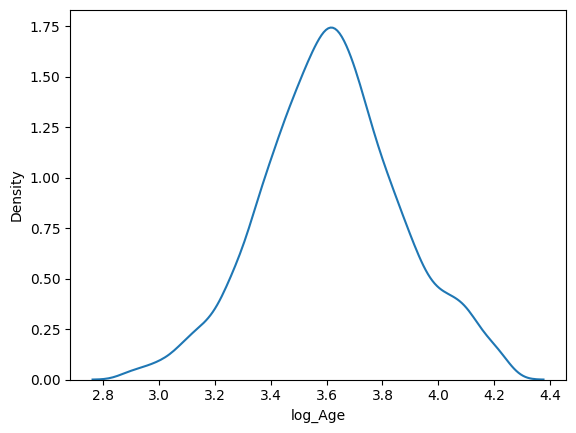

In [145]:
df_train['log_Age'] = np.log(df_train['Age'])

sns.kdeplot(x='log_Age', data=df_train)

In [146]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_train["CreditScore_std"] = MinMaxScaler().fit_transform(df_train['CreditScore'].values.reshape(len(df_train),1))
df_train["Balance_std"] = MinMaxScaler().fit_transform(df_train["Balance"].values.reshape(len(df_train),1))
df_train["EstimatedSalary_std"] = MinMaxScaler().fit_transform(df_train["EstimatedSalary"].values.reshape(len(df_train),1))
df_train["log_Age_std"] = MinMaxScaler().fit_transform(df_train["log_Age"].values.reshape(len(df_train),1))

In [147]:
df_train.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,log_Age,CreditScore_std,Balance_std,EstimatedSalary_std,log_Age_std
count,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000,6903.000000
mean,652.187600,0.452122,38.412285,4.987687,76519.063552,1.525279,0.705925,0.509344,100894.829394,0.209184,3.617439,0.592139,0.304981,0.504325,0.535347
std,96.138893,0.497738,9.705013,2.883620,62524.711702,0.581435,0.455659,0.499949,57640.488043,0.406756,0.248623,0.198225,0.249204,0.288374,0.183064
min,365.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000,2.890372,0.000000,0.000000,0.000000,0.000000
25%,585.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51939.430000,0.000000,3.465736,0.453608,0.000000,0.259402,0.423646
50%,653.000000,0.000000,37.000000,5.000000,96654.720000,1.000000,1.000000,1.000000,100919.190000,0.000000,3.610918,0.593814,0.385235,0.504447,0.530545
75%,720.000000,1.000000,43.000000,7.000000,127878.415000,2.000000,1.000000,1.000000,150411.940000,0.000000,3.761200,0.731959,0.509683,0.752058,0.641200
max,850.000000,1.000000,70.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000,4.248495,1.000000,1.000000,1.000000,1.000000


In [148]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6903 entries, 9069 to 7270
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          6903 non-null   int64  
 1   Gender               6903 non-null   int64  
 2   Age                  6903 non-null   int64  
 3   Tenure               6903 non-null   int64  
 4   Balance              6903 non-null   float64
 5   NumOfProducts        6903 non-null   int64  
 6   HasCrCard            6903 non-null   int64  
 7   IsActiveMember       6903 non-null   int64  
 8   EstimatedSalary      6903 non-null   float64
 9   Geography_France     6903 non-null   bool   
 10  Geography_Germany    6903 non-null   bool   
 11  Geography_Spain      6903 non-null   bool   
 12  Exited               6903 non-null   int64  
 13  log_Age              6903 non-null   float64
 14  CreditScore_std      6903 non-null   float64
 15  Balance_std          6903 non-null   flo

In [149]:
df_train = df_train.drop(columns=['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'log_Age'])

In [150]:
df_train.to_csv('cm_train_final_non_classimbhandling.csv', index = False)

In [151]:
# Class Imbalance Handling

In [155]:
Xt = df_train[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
               'Geography_France', 'Geography_Germany', 'Geography_Spain',
               'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
yt = df_train[['Exited']]

from imblearn import under_sampling, over_sampling
Xt_under, yt_under = under_sampling.RandomUnderSampler().fit_resample(Xt, yt)
Xt_over, yt_over = over_sampling.RandomOverSampler().fit_resample(Xt, yt)
Xt_over_SMOTE, yt_over_SMOTE = over_sampling.SMOTE().fit_resample(Xt, yt)

In [156]:
print(yt.value_counts())
print(yt_under.value_counts())
print(yt_over.value_counts())
print(yt_over_SMOTE.value_counts())

Exited
0         5459
1         1444
Name: count, dtype: int64
Exited
0         1444
1         1444
Name: count, dtype: int64
Exited
0         5459
1         5459
Name: count, dtype: int64
Exited
0         5459
1         5459
Name: count, dtype: int64


In [157]:
print(Xt.shape)
print(Xt_under.shape)
print(Xt_over.shape)
print(Xt_over_SMOTE.shape)

(6903, 12)
(2888, 12)
(10918, 12)
(10918, 12)


In [158]:
XtYt_smote = Xt_over_SMOTE.join(yt_over_SMOTE)
XtYt_smote.head()

,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,CreditScore_std,Balance_std,EstimatedSalary_std,log_Age_std,Exited
0,1,4,2,1,1,False,False,True,0.523711,0.699113,0.864027,0.423646,1
1,1,7,1,0,1,False,True,False,0.573196,0.639407,0.942778,0.468285,0
2,0,6,2,0,0,True,False,False,0.404124,0.000000,0.868470,0.446304,0
3,0,8,1,1,1,False,True,False,0.521649,0.150271,0.979011,0.606131,0
4,0,9,2,0,1,True,False,False,0.719588,0.591742,0.756406,0.530545,0


In [159]:
XtYt_smote.to_csv('cm_train_final.csv',index = False)

# Test Data Preprocessing(Log Transformation and Standardization)

In [160]:
df_test = X_test.join(y_test)
df_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
6252,596,0,32,3,96709.07,2,0,0,41788.37,False,True,False,0
4684,623,0,43,1,0.00,2,1,1,146379.30,True,False,False,0
1731,601,1,44,4,0.00,2,1,0,58561.31,False,False,True,0
4742,506,0,59,8,119152.10,2,1,1,170679.74,False,True,False,0
4521,560,1,27,7,124995.98,1,1,1,114669.79,False,False,True,0


<Axes: xlabel='Age', ylabel='Density'>

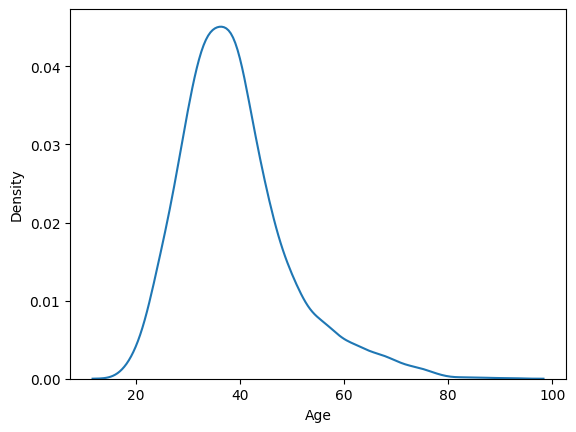

In [161]:
sns.kdeplot(x = 'Age', data = df_test)

<Axes: xlabel='log_Age', ylabel='Density'>

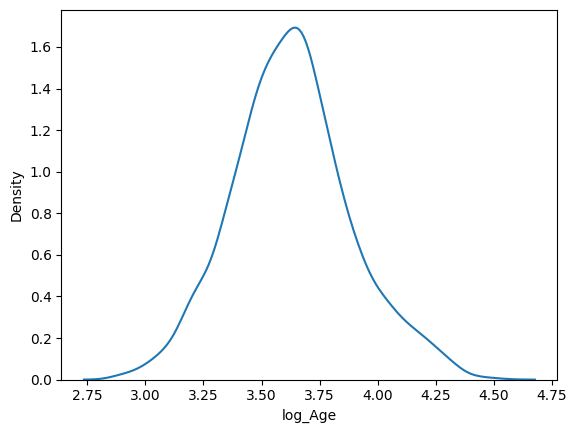

In [162]:
df_test['log_Age'] = np.log(df_test['Age'])

sns.kdeplot(x = 'log_Age', data = df_test)

In [163]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_test['CreditScore_std'] = MinMaxScaler().fit_transform(df_test['CreditScore'].values.reshape(len(df_test), 1))
df_test['Balance_std'] = MinMaxScaler().fit_transform(df_test['Balance'].values.reshape(len(df_test), 1))
df_test['EstimatedSalary_std'] = MinMaxScaler().fit_transform(df_test['EstimatedSalary'].values.reshape(len(df_test), 1))
df_test['log_Age_std'] = MinMaxScaler().fit_transform(df_test['log_Age'].values.reshape(len(df_test), 1))

In [164]:
df_test = df_test.drop(columns=['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'log_Age'])

In [165]:
Xts = df_test[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
               'Geography_France', 'Geography_Germany', 'Geography_Spain',
               'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
yts = df_test[['Exited']]

In [166]:
XtsYts = Xts.join(yts)
XtsYts.head()

,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,CreditScore_std,Balance_std,EstimatedSalary_std,log_Age_std,Exited
6252,0,3,2,0,0,False,True,False,0.492,0.447500,0.208904,0.352678,0
4684,0,1,2,1,1,True,False,False,0.546,0.000000,0.731908,0.533787,0
1731,1,4,2,1,0,False,False,True,0.502,0.000000,0.292777,0.547878,0
4742,0,8,2,1,1,False,True,False,0.312,0.551350,0.853422,0.727690,0
4521,1,7,1,1,1,False,False,True,0.420,0.578391,0.573346,0.248536,0


In [167]:
XtsYts.to_csv('cm_test_final.csv', index = False)

# ML PROCESS

In [169]:
mcln_train = pd.read_csv('/content/cm_train_final.csv')
mcln_test = pd.read_csv('/content/cm_test_final.csv')

# Training
X_train = mcln_train[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                      'Geography_France', 'Geography_Germany', 'Geography_Spain',
                      'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
y_train = mcln_train[['Exited']]

# Testing
X_test = mcln_test[['Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                    'Geography_France', 'Geography_Germany', 'Geography_Spain',
                    'CreditScore_std', 'Balance_std', 'EstimatedSalary_std', 'log_Age_std']]
y_test = mcln_test[['Exited']]

In [170]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    #print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    #print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    #print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    #print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))

    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
#     print("AUC (test-label): %.2f" % roc_auc_score(y_test, y_pred))
#     print("AUC (train-label): %.2f" % roc_auc_score(y_train, y_pred_train))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

### LogisticRegression

In [171]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

eval_classification(lr)

Accuracy (Test Set): 0.79
Precision (Test Set): 0.46
Recall (Test Set): 0.55
F1-Score (Test Set): 0.50
AUC (test-proba): 0.78
AUC (train-proba): 0.80


### Random Forest Classifier

In [172]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

eval_classification(rf)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.62
Recall (Test Set): 0.48
F1-Score (Test Set): 0.54
AUC (test-proba): 0.84
AUC (train-proba): 1.00


In [173]:
# Tuning Hyperparameter Random Forest classifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_leaf = [int(x) for x in np.linspace(2, 150, 50)]
random_state = 1
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf.fit(X_train, y_train)
rs_rf = RandomizedSearchCV(rf, hyperparameters, scoring = 'roc_auc', cv = 5)
rs_rf.fit(X_train, y_train)
eval_classification(rs_rf)

Accuracy (Test Set): 0.85
Precision (Test Set): 0.62
Recall (Test Set): 0.53
F1-Score (Test Set): 0.57
AUC (test-proba): 0.85
AUC (train-proba): 0.99


In [175]:
show_best_hyperparameter(rs_rf)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 86, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 143, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [176]:
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators = 74, max_depth = 70, min_samples_split = 78, min_samples_leaf = 2, random_state = 42)
score = cross_validate(model, X, y, cv = 5, scoring = 'roc_auc', return_train_score = True)

print('roc_auc(train): ' + str(score['train_score'].mean()))
print('roc_auc(test): ' + str(score['test_score'].mean()))

roc_auc(train): 0.9127702755580032
roc_auc(test): 0.8595490594270793


In [177]:
from sklearn.ensemble import RandomForestClassifier
rf_tuned = RandomForestClassifier(n_estimators = 74, max_depth = 70, min_samples_split = 78, min_samples_leaf = 2, random_state = 42)
rf_tuned.fit(X_train,y_train)

eval_classification(rf_tuned)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.61
Recall (Test Set): 0.53
F1-Score (Test Set): 0.57
AUC (test-proba): 0.85
AUC (train-proba): 0.94


param value: 1; train: 0.9354692934701727; test: 0.8535895117028033
param value: 3; train: 0.9343610637622678; test: 0.8520189320058061
param value: 5; train: 0.9341885509260677; test: 0.8508650945749796
param value: 7; train: 0.9321691339872401; test: 0.8510281060056246
param value: 9; train: 0.9316350857888113; test: 0.8507297242130092
param value: 11; train: 0.9311563047837732; test: 0.8527205899029302
param value: 13; train: 0.9295431872848812; test: 0.8501421743173365
param value: 15; train: 0.9291110159529575; test: 0.8524675678127551
param value: 17; train: 0.9281256357866452; test: 0.8524973351174817
param value: 19; train: 0.9271577048860058; test: 0.8517659099156311
param value: 21; train: 0.9262438331526718; test: 0.8517311813934499
param value: 23; train: 0.9260708169722698; test: 0.8484525254014333
param value: 25; train: 0.924817154346238; test: 0.8517815023133448
param value: 27; train: 0.9217492714344346; test: 0.8501669804046086
param value: 29; train: 0.92120287452491

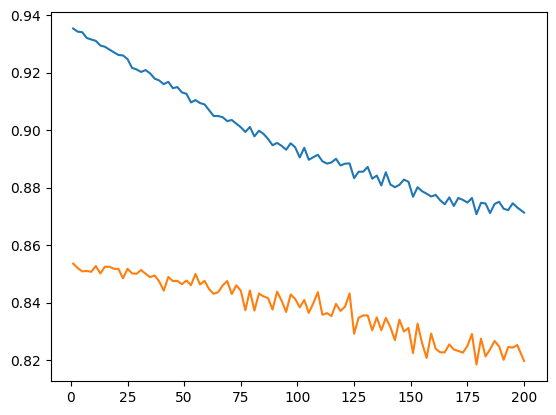

In [178]:
param_values = [int(x) for x in np.linspace(1, 200, 100)]

train_scores = []
test_scores = []

for crf in param_values:
  model = RandomForestClassifier(n_estimators = 118, max_depth = 28, min_samples_split = 98, min_samples_leaf = crf)
  model.fit(X_train, y_train)

  y_pred_train_proba = model.predict_proba(X_train)
  train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
  train_scores.append(train_auc)

  y_pred_proba = model.predict_proba(X_test)
  test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  test_scores.append(test_auc)

  print('param value: ' + str(crf) + '; train: ' + str(train_auc) + '; test: ' + str(test_auc))

plt.plot(param_values, train_scores, label = 'Train')
plt.plot(param_values, test_scores, label = 'Test')
plt.show()

n_estimator 118 max_depth 28 min_samples_split 98 min_samples_leaf 164

After hyperparameter tuning, the results showed that the most appropriate values for the n_estimators parameter were 118, max_depth = 27 and min_sample_leaf = 135.

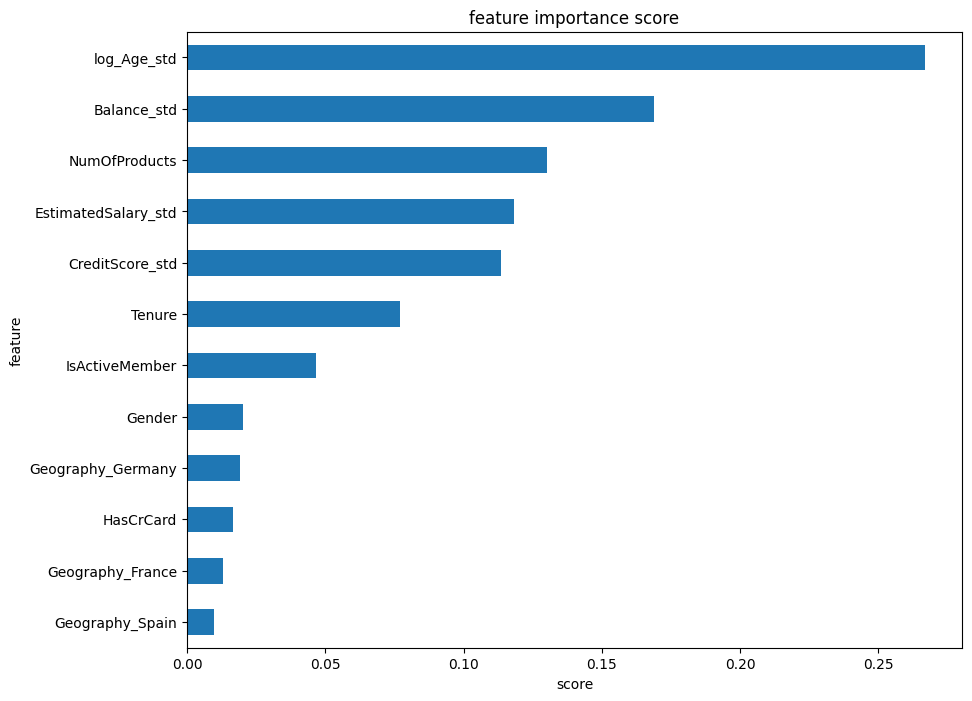

In [179]:
show_feature_importance(rf)

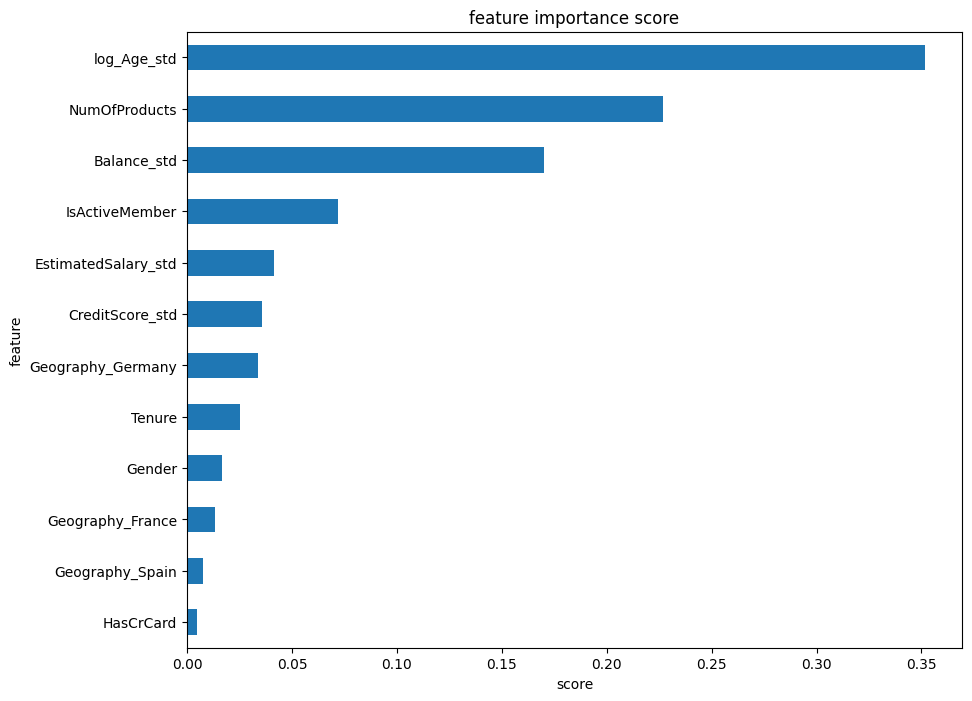

In [180]:
show_feature_importance(rf_tuned)